In [219]:
%%capture
!pip install libpysal esda geopandas
!pip install splot
!pip install mlxtend

In [220]:
# Importer les bibliothèques nécessaires
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from mlxtend.frequent_patterns import apriori, association_rules
import community.community_louvain as community_louvain
from libpysal.weights import KNN, Queen
from esda.moran import Moran
import geopandas as gpd
from splot.esda import moran_scatterplot

In [221]:
def load_and_prepare_data(file_path):
    """Charge et prépare les données en appliquant un encodage one-hot pour les variables catégorielles
    et une normalisation pour les variables numériques."""
    df = pd.read_csv(file_path)
    categorical_columns = df.select_dtypes(include=['object']).columns
    if len(categorical_columns) > 0:
        df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)
    numerical_columns = ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']
    scaler = StandardScaler()
    df[numerical_columns] = scaler.fit_transform(df[numerical_columns])
    return df

# Charger les données
file_path = '/content/ObesityDataSet.csv'
df = load_and_prepare_data(file_path)
df.head()

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE,Gender_Male,family_history_with_overweight_yes,...,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking,NObeyesdad_Normal_Weight,NObeyesdad_Obesity_Type_I,NObeyesdad_Obesity_Type_II,NObeyesdad_Obesity_Type_III,NObeyesdad_Overweight_Level_I,NObeyesdad_Overweight_Level_II
0,-0.522124,-0.875589,-0.862558,-0.785019,0.404153,-0.013073,-1.188039,0.561997,False,True,...,False,False,True,False,True,False,False,False,False,False
1,-0.522124,-1.947599,-1.168077,1.088342,0.404153,1.618759,2.339750,-1.080625,False,True,...,False,False,True,False,True,False,False,False,False,False
2,-0.206889,1.054029,-0.366090,-0.785019,0.404153,-0.013073,1.163820,0.561997,True,True,...,False,False,True,False,True,False,False,False,False,False
3,0.423582,1.054029,0.015808,1.088342,0.404153,-0.013073,1.163820,-1.080625,True,False,...,False,False,False,True,False,False,False,False,True,False
4,-0.364507,0.839627,0.122740,-0.785019,-2.167023,-0.013073,-1.188039,-1.080625,True,False,...,False,False,True,False,False,False,False,False,False,True


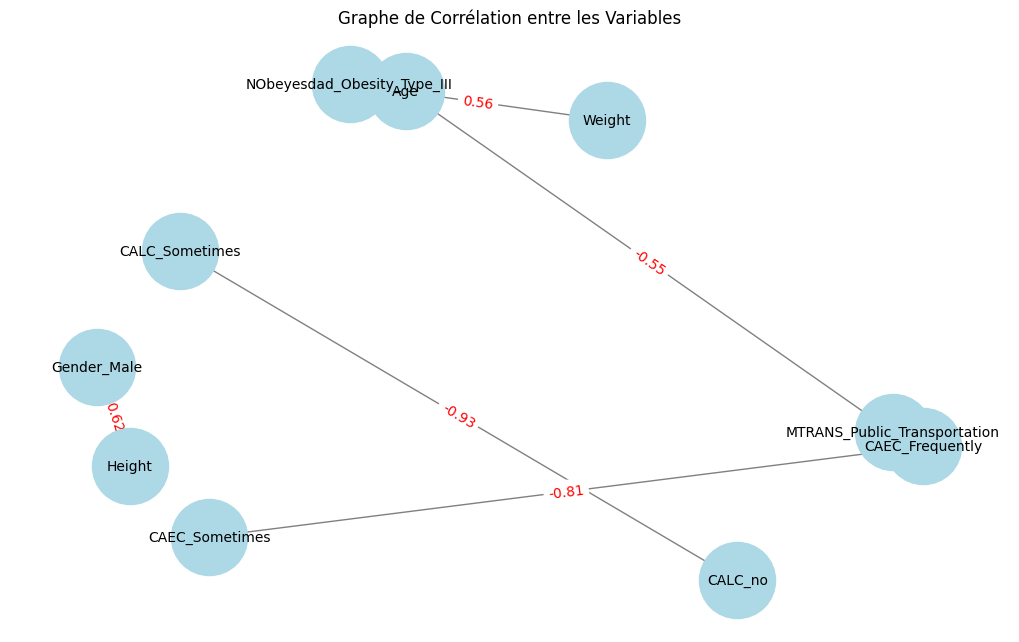

In [222]:
RANDOM_STATE = 42

def plot_correlation_graph(correlation_matrix, threshold=0.5):
    """Crée et affiche un graphe NetworkX basé sur les corrélations significatives."""
    G = nx.Graph()
    for i, var1 in enumerate(correlation_matrix.columns):
        for j, var2 in enumerate(correlation_matrix.columns):
            if i < j:
                correlation = correlation_matrix.iloc[i, j]
                if abs(correlation) >= threshold:
                    G.add_edge(var1, var2, weight=correlation)

    # Sous-graphe pour nœuds ayant des arêtes
    subgraph = G.subgraph([node for node, degree in G.degree() if degree > 0])
    plt.figure(figsize=(10, 6))
    pos = nx.spring_layout(subgraph, k=0.8, seed=RANDOM_STATE)
    nx.draw(subgraph, pos, with_labels=True, node_color='lightblue', edge_color='gray', font_size=10, node_size=3000)

    # Étiquettes des arêtes
    edge_labels = nx.get_edge_attributes(subgraph, 'weight')
    nx.draw_networkx_edge_labels(
        subgraph,
        pos,
        edge_labels={edge: f"{weight:.2f}" for edge, weight in edge_labels.items()},
        font_color='red'
    )
    plt.title("Graphe de Corrélation entre les Variables")
    plt.show()


# Matrice de corrélation et graphe
correlation_matrix = df.corr()
plot_correlation_graph(correlation_matrix, threshold=0.5)

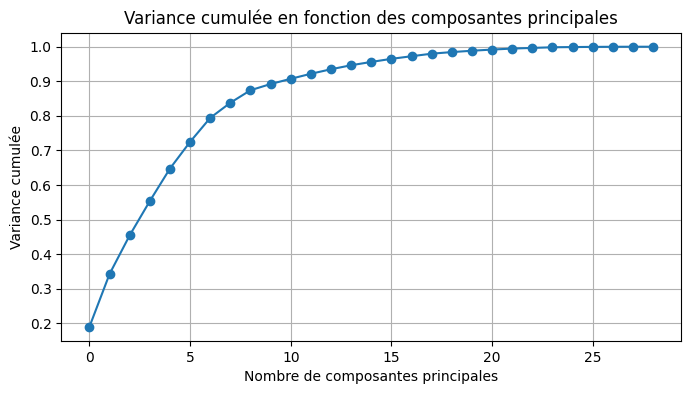

In [223]:
pca = PCA().fit(df)
plt.figure(figsize=(8, 4))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Nombre de composantes principales')
plt.ylabel('Variance cumulée')
plt.title('Variance cumulée en fonction des composantes principales')
plt.grid()
plt.show()


In [224]:
pca = PCA().fit(df)
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

for i, variance in enumerate(cumulative_variance, start=1):
    print(f"{i} composante(s) : Variance cumulée = {variance:.2%}")


1 composante(s) : Variance cumulée = 18.98%
2 composante(s) : Variance cumulée = 34.26%
3 composante(s) : Variance cumulée = 45.44%
4 composante(s) : Variance cumulée = 55.36%
5 composante(s) : Variance cumulée = 64.75%
6 composante(s) : Variance cumulée = 72.48%
7 composante(s) : Variance cumulée = 79.41%
8 composante(s) : Variance cumulée = 83.79%
9 composante(s) : Variance cumulée = 87.41%
10 composante(s) : Variance cumulée = 89.20%
11 composante(s) : Variance cumulée = 90.72%
12 composante(s) : Variance cumulée = 92.17%
13 composante(s) : Variance cumulée = 93.48%
14 composante(s) : Variance cumulée = 94.64%
15 composante(s) : Variance cumulée = 95.60%
16 composante(s) : Variance cumulée = 96.49%
17 composante(s) : Variance cumulée = 97.25%
18 composante(s) : Variance cumulée = 97.98%
19 composante(s) : Variance cumulée = 98.45%
20 composante(s) : Variance cumulée = 98.83%
21 composante(s) : Variance cumulée = 99.18%
22 composante(s) : Variance cumulée = 99.46%
23 composante(s) : 

In [225]:
def apply_pca(data, n_components=10):
    """Réduit la dimension des données avec PCA en spécifiant un nombre fixe de composantes principales."""
    pca = PCA(n_components=n_components, random_state=RANDOM_STATE)
    reduced_data = pca.fit_transform(data)
    print(f"Nombre de composantes principales retenues : {n_components}")
    return reduced_data

df_pca = apply_pca(df, n_components=2)


Nombre de composantes principales retenues : 2


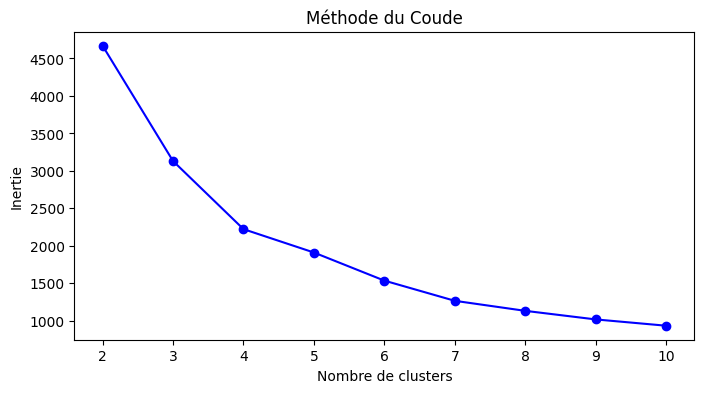

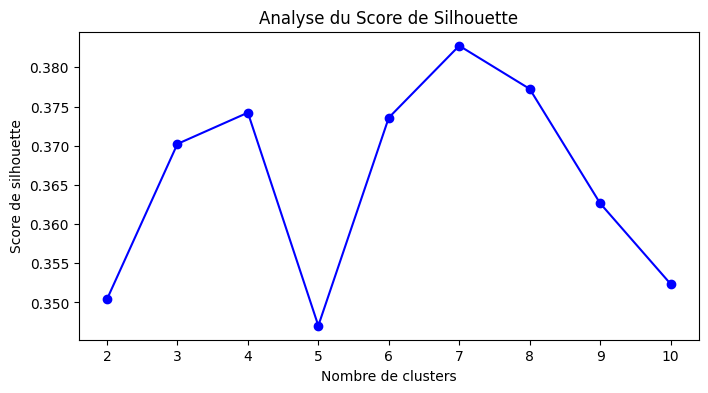

In [226]:
def elbow_method(data, max_clusters=10):
    """Affiche la méthode du coude pour déterminer le meilleur nombre de clusters."""
    inertias = []
    for k in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE)
        kmeans.fit(data)
        inertias.append(kmeans.inertia_)

    plt.figure(figsize=(8, 4))
    plt.plot(range(2, max_clusters + 1), inertias, 'bo-')
    plt.xlabel('Nombre de clusters')
    plt.ylabel('Inertie')
    plt.title("Méthode du Coude")
    plt.show()

def silhouette_analysis(data, max_clusters=10):
    """Affiche le score de silhouette pour différents nombres de clusters."""
    silhouette_scores = []
    for k in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE)
        labels = kmeans.fit_predict(data)
        silhouette_scores.append(silhouette_score(data, labels))

    plt.figure(figsize=(8, 4))
    plt.plot(range(2, max_clusters + 1), silhouette_scores, 'bo-')
    plt.xlabel('Nombre de clusters')
    plt.ylabel('Score de silhouette')
    plt.title("Analyse du Score de Silhouette")
    plt.show()

# Exécuter les analyses
elbow_method(df_pca)
silhouette_analysis(df_pca)


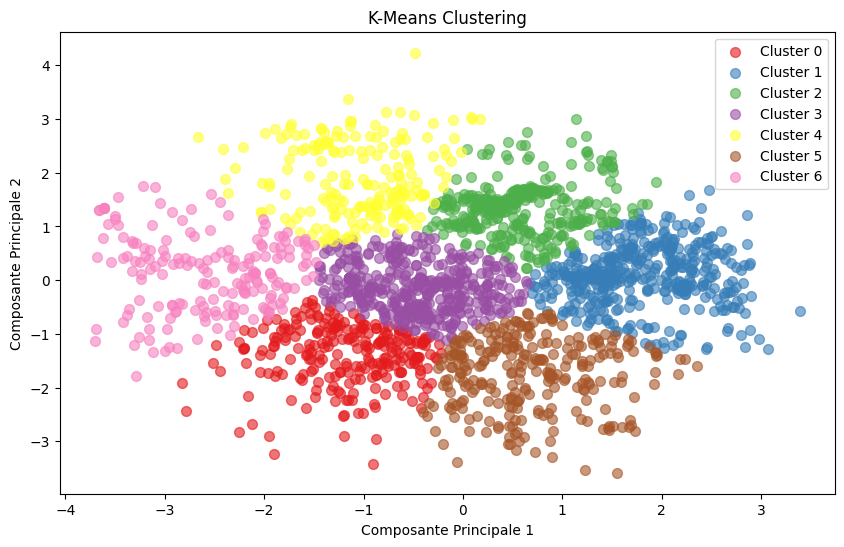

In [227]:
def apply_kmeans(data, n_clusters=7):
    """Applique l'algorithme K-Means sur les données."""
    kmeans = KMeans(n_clusters=n_clusters, random_state=RANDOM_STATE)
    return kmeans.fit_predict(data)

def apply_dbscan(data, eps=0.6, min_samples=11):
    """Applique l'algorithme DBSCAN sur les données."""
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    return dbscan.fit_predict(data)

def plot_clusters(data_2d, labels, title):
    """Visualise les clusters en 2D."""
    plt.figure(figsize=(10, 6))
    unique_labels = set(labels)
    for label in unique_labels:
        color = 'k' if label == -1 else plt.cm.Set1(label / float(max(unique_labels) + 1))
        plt.scatter(data_2d[labels == label, 0], data_2d[labels == label, 1],
                    c=[color], label=f'Cluster {label}' if label != -1 else 'Bruit', s=50, alpha=0.6)
    plt.title(title)
    plt.xlabel('Composante Principale 1')
    plt.ylabel('Composante Principale 2')
    plt.legend()
    plt.show()

# Exemple de clustering
df_pca_2d = PCA(n_components=2, random_state=RANDOM_STATE).fit_transform(df)
kmeans_labels = apply_kmeans(df_pca)
plot_clusters(df_pca_2d, kmeans_labels, 'K-Means Clustering')

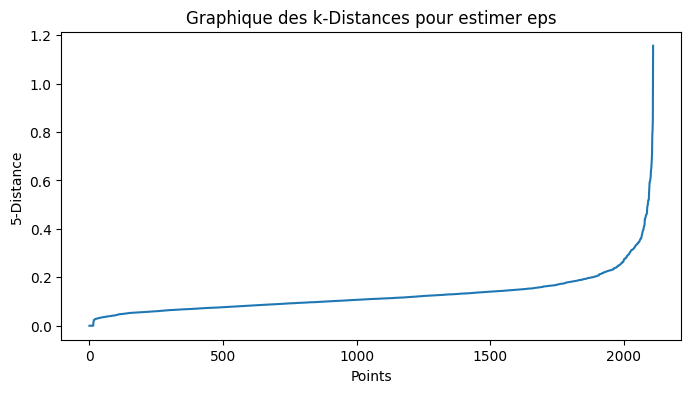

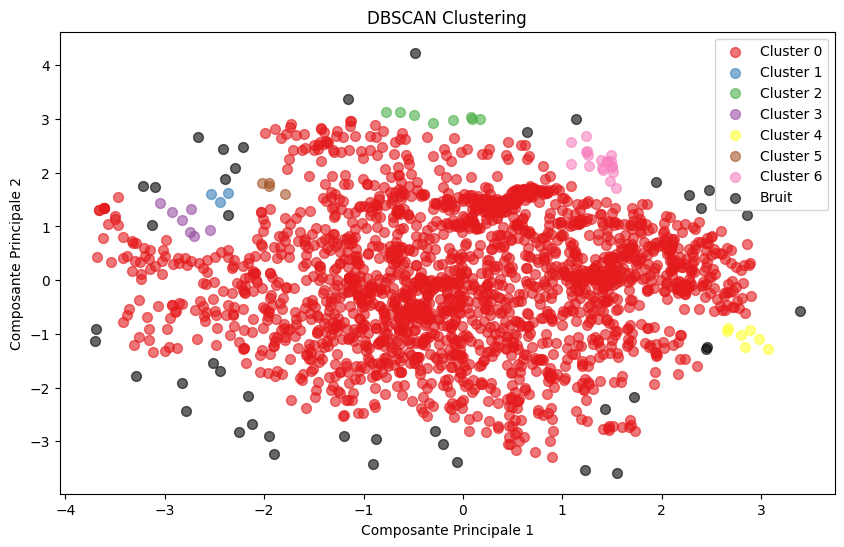

In [228]:
def plot_k_distances(data, k=5):
    """Affiche le graphique des k-distances pour aider à déterminer le paramètre eps pour DBSCAN."""
    neighbors = NearestNeighbors(n_neighbors=k)
    neighbors_fit = neighbors.fit(data)
    distances, _ = neighbors_fit.kneighbors(data)
    distances = np.sort(distances[:, k - 1], axis=0)

    plt.figure(figsize=(8, 4))
    plt.plot(distances)
    plt.xlabel("Points")
    plt.ylabel(f"{k}-Distance")
    plt.title("Graphique des k-Distances pour estimer eps")
    plt.show()

# Afficher le graphique des k-distances
plot_k_distances(df_pca, k=5)

# Appliquer DBSCAN
dbscan_labels = apply_dbscan(df_pca, eps=0.25, min_samples=3)
plot_clusters(df_pca_2d, dbscan_labels, 'DBSCAN Clustering')


Fichier sauvegardé : frequent_itemsets.csv
Fichier sauvegardé : association_rules.csv


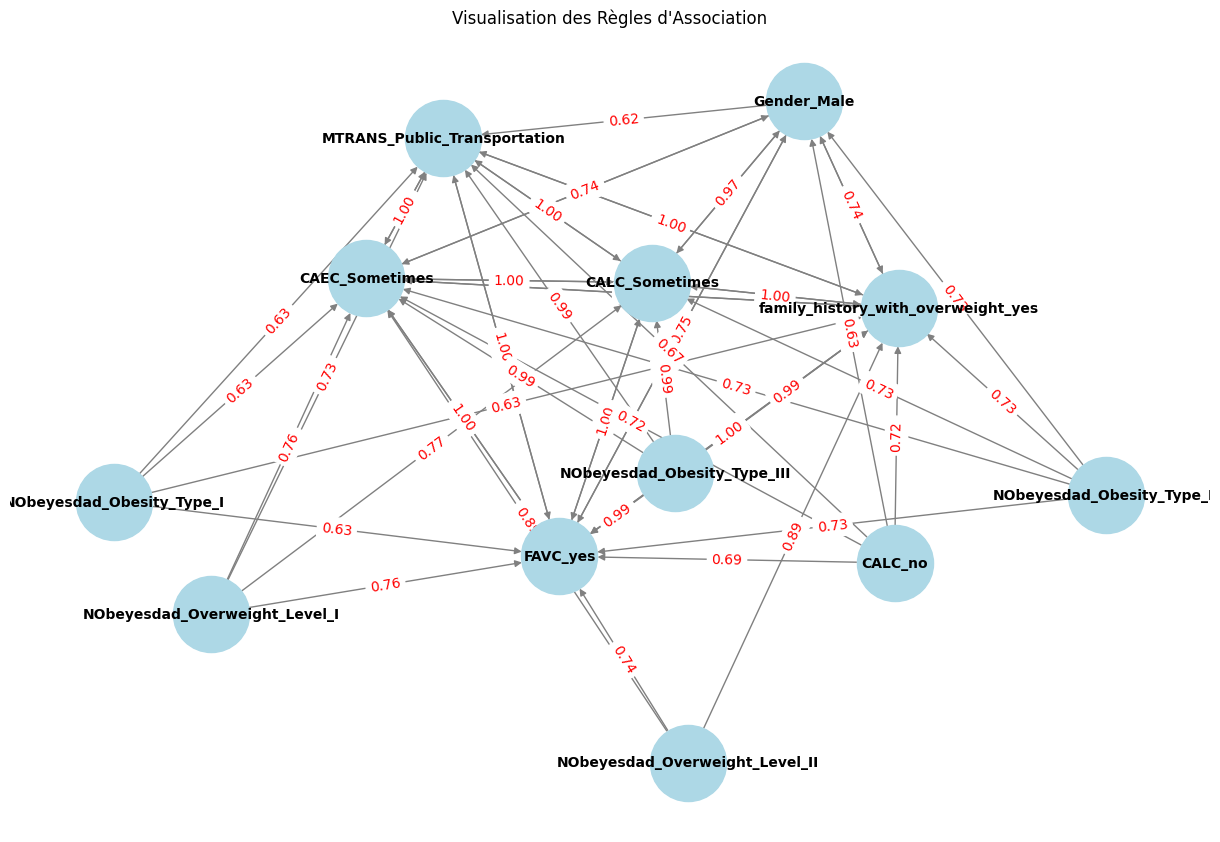

In [229]:
def prepare_data_for_association(df):
    """Prépare les données pour l'extraction de motifs fréquents."""
    return df.select_dtypes(include=['uint8', 'bool'])

def extract_frequent_itemsets(data, min_support=0.1):
    """Extrait les itemsets fréquents avec l'algorithme Apriori."""
    return apriori(data, min_support=min_support, use_colnames=True)

def generate_association_rules(frequent_itemsets, min_confidence=0.6):
    """Génère des règles d'association à partir des itemsets fréquents."""
    return association_rules(frequent_itemsets, metric="confidence", min_threshold=min_confidence)

def save_to_csv(dataframe, filename):
    """Sauvegarde un DataFrame dans un fichier CSV."""
    dataframe.to_csv(filename, index=False)
    print(f"Fichier sauvegardé : {filename}")

# Extraction des motifs fréquents
binary_df = prepare_data_for_association(df)
frequent_itemsets = extract_frequent_itemsets(binary_df, min_support=0.1)
rules = generate_association_rules(frequent_itemsets, min_confidence=0.6)

# Sauvegarde des résultats
save_to_csv(frequent_itemsets, "frequent_itemsets.csv")
save_to_csv(rules, "association_rules.csv")

# Visualisation des règles d'association
def plot_association_rules(rules):
    """Affiche un graphe des règles d'association."""
    G = nx.DiGraph()

    # Ajouter des arêtes au graphe en fonction des règles
    for _, rule in rules.iterrows():
        for antecedent in rule['antecedents']:
            for consequent in rule['consequents']:
                G.add_edge(antecedent, consequent, weight=rule['confidence'])

    # Vérifier si le graphe est vide
    if G.number_of_edges() == 0:
        print("Aucune règle d'association significative à afficher.")
        return

    # Dessiner le graphe
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G, k=0.5, seed=RANDOM_STATE)
    nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray',
            font_size=10, node_size=3000, font_weight='bold')

    # Récupérer les étiquettes des arêtes
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(
        G,
        pos,
        edge_labels={edge: f"{weight:.2f}" for edge, weight in edge_labels.items()},
        font_color='red'
    )
    plt.title("Visualisation des Règles d'Association")
    plt.show()

# Afficher les règles sous forme de graphe
plot_association_rules(rules)

<ipython-input-230-5ad4838681d2>:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20', max(partition.values()) + 1)


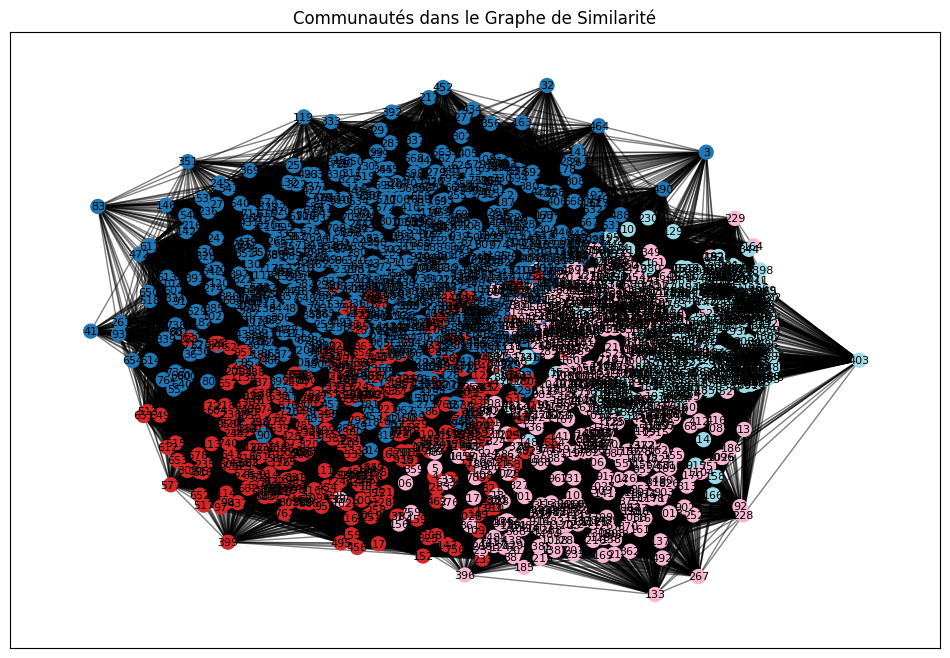

In [230]:
def create_similarity_graph(data, threshold=0.5):
    """Crée un graphe de similarité basé sur une matrice de similarité cosinus."""
    similarity_matrix = cosine_similarity(data)
    G = nx.Graph()
    for i in range(len(similarity_matrix)):
        for j in range(i + 1, len(similarity_matrix)):
            if similarity_matrix[i, j] > threshold:
                G.add_edge(i, j, weight=similarity_matrix[i, j])
    return G

# Graphe de similarité
similarity_graph = create_similarity_graph(df)
partition = community_louvain.best_partition(similarity_graph)

def plot_community_graph(graph, partition):
    """Affiche les communautés détectées dans un graphe."""
    pos = nx.spring_layout(graph, seed=RANDOM_STATE)
    plt.figure(figsize=(12, 8))
    cmap = plt.cm.get_cmap('tab20', max(partition.values()) + 1)
    nx.draw_networkx_nodes(graph, pos, node_size=100, cmap=cmap, node_color=list(partition.values()))
    nx.draw_networkx_edges(graph, pos, alpha=0.5)
    nx.draw_networkx_labels(graph, pos, font_size=8)
    plt.title("Communautés dans le Graphe de Similarité")
    plt.show()

plot_community_graph(similarity_graph, partition)

In [231]:
# Ajouter les résultats de clustering au DataFrame
df['KMeans_Cluster'] = kmeans_labels
df['DBSCAN_Cluster'] = dbscan_labels

# Moyennes par cluster pour K-Means
kmeans_cluster_means = df.groupby('KMeans_Cluster').mean()
print("Moyennes par Cluster (K-Means) :")
print(kmeans_cluster_means)


Moyennes par Cluster (K-Means) :
                     Age    Height    Weight      FCVC       NCP      CH2O  \
KMeans_Cluster                                                               
0              -0.711172 -0.514623 -1.025471 -0.579783  0.259751 -0.291784   
1               0.058437  0.992836  1.222358  0.295177  0.308128  0.479933   
2               0.772011 -0.026728  0.709032  0.487537  0.157297  0.077019   
3              -0.286214 -0.166698 -0.327067 -0.125616 -0.191510 -0.058626   
4               1.525526 -0.906935 -0.228796  0.091938 -0.496163 -0.664203   
5              -0.670693  0.801690 -0.387170 -0.291104  0.486102  0.554476   
6              -0.552069 -1.449308 -1.209702 -0.171498 -1.150563 -0.869527   

                     FAF       TUE  Gender_Male  \
KMeans_Cluster                                    
0               0.250258  0.935281     0.313725   
1               0.376054 -0.041683     0.696552   
2              -0.576308 -0.586133     0.473684   
3        

In [232]:
# Moyennes par cluster pour DBSCAN
dbscan_cluster_means = df.groupby('DBSCAN_Cluster').mean()
print("Moyennes par Cluster (DBSCAN) :")
print(dbscan_cluster_means)

Moyennes par Cluster (DBSCAN) :
                     Age    Height    Weight      FCVC       NCP      CH2O  \
DBSCAN_Cluster                                                               
-1              0.335698 -0.366616 -0.517213 -0.559592 -0.193534 -0.236501   
 0             -0.046816  0.005991  0.002397  0.019190  0.008278  0.009754   
 1              1.060641 -1.590856 -0.851051 -0.160565 -1.693234 -1.396551   
 2              4.171017 -0.290147 -0.230369  0.139912  0.287444 -0.651801   
 3              0.376074 -1.834190 -1.076511 -0.452058 -1.267376 -1.065314   
 4             -0.556556  2.596916  1.123410 -0.517396  0.587808  1.618759   
 5              0.536270 -1.465122 -0.284640 -0.721143 -1.795642 -0.173383   
 6              2.247418  0.593596  1.189705 -0.298375  0.332598 -0.174262   

                     FAF       TUE  Gender_Male  \
DBSCAN_Cluster                                    
-1              0.329196  0.649792     0.418605   
 0              0.005831  0.002141

In [233]:
# Moyennes par communauté Louvain
communities = pd.Series(partition).to_frame(name='Community').reset_index()
df_with_communities = df.merge(communities, left_index=True, right_on='index')
community_means = df_with_communities.groupby('Community').mean()
print("Moyennes par Communauté (Louvain) :")
print(community_means)

Moyennes par Communauté (Louvain) :
                Age    Height    Weight      FCVC       NCP      CH2O  \
Community                                                               
0         -0.594941 -0.051384 -0.692422 -0.293800  0.559273 -0.074493   
1         -0.352914 -0.615746 -0.508737 -0.095069 -1.894484 -0.137005   
2          1.146928  0.440249  0.461890 -0.300919  0.064417 -0.112076   
3         -0.088734  0.019775  1.115731  1.024604  0.390485  0.397734   

                FAF       TUE  Gender_Male  \
Community                                    
0          0.360325  0.341758     0.549561   
1         -0.300289  0.061529     0.401760   
2         -0.060468 -0.479116     0.758621   
3         -0.358916 -0.069597     0.177725   

           family_history_with_overweight_yes  ...  MTRANS_Walking  \
Community                                      ...                   
0                                    0.701380  ...        0.046424   
1                                    0

In [234]:
def analyze_communities(data, partition):
    """Analyse les statistiques descriptives pour chaque communauté."""
    communities = {}
    for node, comm in partition.items():
        if comm not in communities:
            communities[comm] = []
        communities[comm].append(node)

    for comm, members in communities.items():
        print(f"\nAnalyse pour la Communauté {comm}")
        subset = data.iloc[members]
        print(subset.describe())

# Analyse par communauté
analyze_communities(df, partition)



Analyse pour la Communauté 0
              Age      Height      Weight        FCVC         NCP        CH2O  \
count  797.000000  797.000000  797.000000  797.000000  797.000000  797.000000   
mean    -0.594941   -0.051384   -0.692422   -0.293800    0.559273   -0.074493   
std      0.426404    0.951328    0.615679    1.039595    0.505441    0.994780   
min     -1.625448   -2.698006   -1.817304   -2.658379   -1.244475   -1.644905   
25%     -0.980149   -0.768388   -1.206941   -0.785019    0.404153   -0.717248   
50%     -0.679742   -0.017574   -0.762438   -0.785019    0.404153   -0.013073   
75%     -0.331453    0.556380   -0.209183    0.920386    0.404153    0.333358   
max      1.526906    2.447641    1.100321    1.088342    1.689740    1.618759   

              FAF         TUE  KMeans_Cluster  DBSCAN_Cluster  
count  797.000000  797.000000      797.000000      797.000000  
mean     0.360325    0.341758        2.956085       -0.022585  
std      1.084102    1.090457        2.164545   

In [235]:
# Ajouter des coordonnées
df['latitude'] = np.random.uniform(-90, 90, size=len(df))
df['longitude'] = np.random.uniform(-180, 180, size=len(df))

# Convertir le DataFrame en GeoDataFrame
geo_df = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))

# Créer une matrice de poids spatiaux (K plus proches voisins)
knn_weights = KNN.from_dataframe(geo_df, k=5)

In [236]:
# Calcul de Moran's I
moran = Moran(df['Weight'], knn_weights)

# Affichage des résultats
print(f"Valeur de Moran's I : {moran.I}")
print(f"p-valeur : {moran.p_sim}")

Valeur de Moran's I : 0.011892938268107339
p-valeur : 0.16


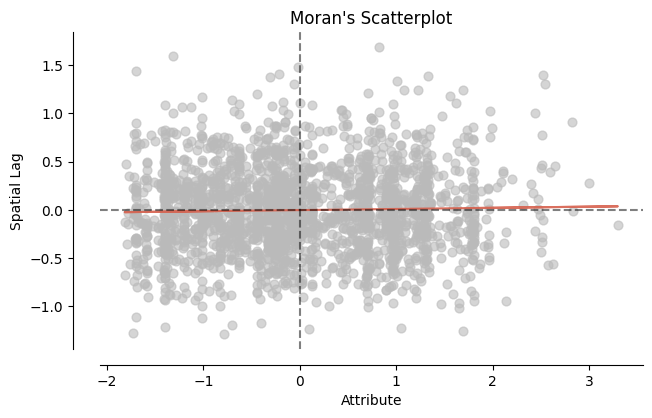

In [237]:
# Tracer le Moran's Plot
fig, ax = moran_scatterplot(moran)
plt.title("Moran's Scatterplot")
plt.show()